# GPU实践 + 在CNN图像分类模型上实践

In [1]:
# 导入
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.18.1
pandas 0.25.3
sklearn 0.22.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


## 设置GPU

### GPU实践1：内存增长和可见

In [2]:
# 打印日志
tf.debugging.set_log_device_placement(True)

# 获取所有物理GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
# 设置某个GPU可见
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
# 设置内存增长
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print(len(gpus))

# 获取所有逻辑GPU
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(logical_gpus))

1
1


### GPU实践2：为GPU做逻辑切分

In [2]:
tf.debugging.set_log_device_placement(True)

# 获取所有物理GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
# 设置某个GPU可见
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
# 逻辑切分
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048),
     tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]
)
print(len(gpus))

# 获取所有逻辑GPU
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(logical_gpus))

1
2


### GPU实践3：手工指定的方式使用多GPU

In [2]:
tf.debugging.set_log_device_placement(True)
tf.config.set_soft_device_placement(True)

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048),
     tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]
)
print(len(gpus))

logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(logical_gpus))

1
2


In [3]:
# 手工指定，进行矩阵计算
c = []
for gpu in logical_gpus:
    print(gpu.name)
    with tf.device(gpu.name):
        a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
        b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
        c.append(tf.matmul(a, b))

with tf.device('/CPU:0'):
    matmul_num = tf.add_n(c)

print(matmul_num)

/job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:1
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op AddN in device /job:localhost/replica:0/task:0/device:CPU:0
tf.Tensor(
[[ 44.  56.]
 [ 98. 128.]], shape=(2, 2), dtype=float32)


## 数据读取

In [3]:
# # 导入数据集fashion mnist
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all,y_train_all),(x_test,y_test) = fashion_mnist.load_data()
x_valid,x_train = x_train_all[:5000],x_train_all[5000:]
y_valid,y_train = y_train_all[:5000],y_train_all[5000:]

print(x_valid.shape,y_valid.shape)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [4]:
# 数据归一化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28,1)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1,1)).reshape(-1,28,28,1)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28,1)

In [5]:
# 生成dataset
def make_dataset(images, labels, epochs, batch_size, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size).prefetch(50)
    return dataset

batch_size = 128
epochs = 100
train_dataset = make_dataset(x_train_scaled, y_train, epochs, batch_size)

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousRandomSeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0


## CNN模型搭建
指定在某个GPU上

好处：当模型很大时，model需要放在不同GPU上，但仍然是串行而非并行

In [6]:
model = keras.models.Sequential()
# 构建模型
with tf.device(logical_gpus[0].name):
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same',
                                  activation='relu', input_shape=(28,28,1)))
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.MaxPool2D(pool_size=2))

    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.MaxPool2D(pool_size=2))

    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.MaxPool2D(pool_size=2))

with tf.device(logical_gpus[1].name):
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))

# 模型编译，固化模型
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         7

In [8]:
# 训练
history = model.fit(
    train_dataset, steps_per_epoch = x_train_scaled.shape[0] // batch_size, epochs=10)

Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Train for 429 steps
Epoch 1/10
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/dev

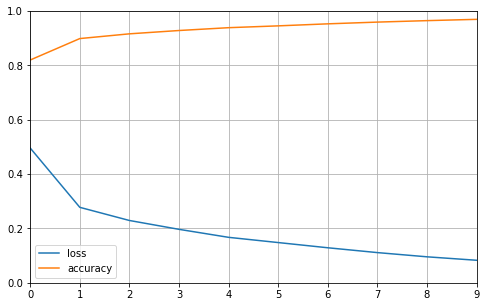

In [9]:
# 画图展示学习曲线图
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
    
plot_learning_curves(history)